In [1]:
# Install necessary libraries
!pip install nltk gensim pyLDAvis

# Import libraries
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models
import pyLDAvis
import matplotlib.pyplot as plt

# Download NLTK stopwords
nltk.download('stopwords')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 68.7 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Step 2: Load the Dataset


In [2]:
# Load the dataset, skipping bad lines
file_path = '/content/athlete_events.csv'  # Replace with your actual file path
data = pd.read_csv(file_path, on_bad_lines='skip')

# Display the first few rows of the dataset
data.head()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


Step 3: Text Preprocessing

In [11]:
import re

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# Ensure 'Event' column exists
if 'Event' in data.columns:
    # Convert non-string values to empty strings
    data['Event'] = data['Event'].fillna('')

    # Apply the preprocessing function
    data['processed_event'] = data['Event'].apply(preprocess_text)

    # Display the processed text
    print(data[['Event', 'processed_event']].head())
else:
    print("Column 'Event' not found in the DataFrame.")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                              Event                  processed_event
0       Basketball Men's Basketball       basketball mens basketball
1      Judo Men's Extra-Lightweight       judo mens extralightweight
2           Football Men's Football           football mens football
3       Tug-Of-War Men's Tug-Of-War           tugofwar mens tugofwar
4  Speed Skating Women's 500 metres  speed skating womens 500 metres


In [13]:
# Combine relevant text fields into one
data['text'] = data['Sport'].fillna('') + ' ' + data['Event'].fillna('') + ' ' + data['Team'].fillna('')

# Function to clean and preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.split()  # Tokenize
    text = [word for word in text if word not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(text)

# Apply preprocessing to the text column
data['processed_text'] = data['text'].apply(preprocess_text)

# Display the processed text
data[['text', 'processed_text']].head()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,processed_text
0,Basketball Basketball Men's Basketball China,basketball basketball mens basketball china
1,Judo Judo Men's Extra-Lightweight China,judo judo mens extralightweight china
2,Football Football Men's Football Denmark,football football mens football denmark
3,Tug-Of-War Tug-Of-War Men's Tug-Of-War Denmark...,tugofwar tugofwar mens tugofwar denmarksweden
4,Speed Skating Speed Skating Women's 500 metres...,speed skating speed skating womens metres neth...


 Create a Document-Term Matrix

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(data['processed_text'])

# Convert to a DataFrame for easier inspection (optional)
dtm_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())
dtm_df.head()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ac,acipactli,aclass,acturus,aerials,af,afghanistan,africa,african,air,...,yemen,yeoman,ylliam,york,yugoslavia,zambia,zealand,zefyros,zimbabwe,zut
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Apply LDA Using Gensim

In [15]:
from gensim import corpora
from gensim.models import LdaModel

# Create a dictionary and corpus required for LDA
corpus = [text.split() for text in data['processed_text']]
id2word = corpora.Dictionary(corpus)
corpus = [id2word.doc2bow(text) for text in corpus]

# Apply LDA model
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=5, random_state=42, passes=10)

# Print the topics
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.104*"mens" + 0.052*"skating" + 0.050*"cycling" + 0.049*"fencing" + 0.039*"speed" + 0.038*"womens" + 0.036*"individual" + 0.036*"team" + 0.033*"wrestling" + 0.032*"volleyball"')
(1, '0.132*"hockey" + 0.125*"mens" + 0.088*"rowing" + 0.073*"football" + 0.069*"ice" + 0.044*"handball" + 0.038*"womens" + 0.026*"bobsleigh" + 0.022*"coxed" + 0.021*"south"')
(2, '0.107*"swimming" + 0.081*"skiing" + 0.066*"mens" + 0.054*"metres" + 0.046*"womens" + 0.041*"cross" + 0.041*"country" + 0.037*"alpine" + 0.029*"freestyle" + 0.026*"sailing"')
(3, '0.241*"athletics" + 0.122*"mens" + 0.069*"metres" + 0.045*"womens" + 0.045*"basketball" + 0.041*"water" + 0.041*"polo" + 0.035*"boxing" + 0.017*"relay" + 0.017*"x"')
(4, '0.160*"gymnastics" + 0.099*"mens" + 0.061*"shooting" + 0.049*"womens" + 0.039*"metres" + 0.034*"canoeing" + 0.031*"tennis" + 0.025*"allaround" + 0.019*"doubles" + 0.019*"team"')


 Visualize the Topics with pyLDAvis

In [16]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Enable PyLDAvis in notebooks
pyLDAvis.enable_notebook()

# Prepare the visualization
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.165539 -0.133117       1        1  25.308998
0     -0.077176  0.053024       2        1  22.274886
4     -0.012050  0.269479       3        1  19.613131
3     -0.064026 -0.119321       4        1  18.015133
1      0.318790 -0.070066       5        1  14.787853, topic_info=            Term          Freq         Total Category  logprob  loglift
23     athletics  77588.000000  77588.000000  Default  30.0000  30.0000
37    gymnastics  56117.000000  56117.000000  Default  29.0000  29.0000
25        hockey  34747.000000  34747.000000  Default  28.0000  28.0000
28      swimming  48298.000000  48298.000000  Default  27.0000  27.0000
17        skiing  36784.000000  36784.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
18        states   2515.068652  17739.105508   Topic5  -4.6532  -0.0421
1          china   2311.790260  17222.337351   Topic5  -4.7375  -0.0968
10   netherlands   1935.836922  10307.354683   Topic5  -4.9150   0.2390
247         west   1576.951471   3840.159607   Topic5  -5.1200   1.0213
183       canada   1610.421354   7788.339827   Topic5  -5.0990   0.3352

[253 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
187       5  0.999308     africa
198       3  0.999699        air
36        3  0.999913  allaround
58        1  0.999934     alpine
191       2  0.999815    archery
...     ...       ...        ...
13        5  0.128449     womens
72        2  0.999936  wrestling
22        1  0.657633          x
22        4  0.342319          x
298       5  0.999866    zealand

[261 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 4, 2])

Save and Share the Results

In [17]:
# Save the LDA model
lda_model.save('lda_model.athlete_events')

# Optionally save the pyLDAvis visualization as an HTML file
pyLDAvis.save_html(vis, 'lda_visualization.html')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Document Similarity

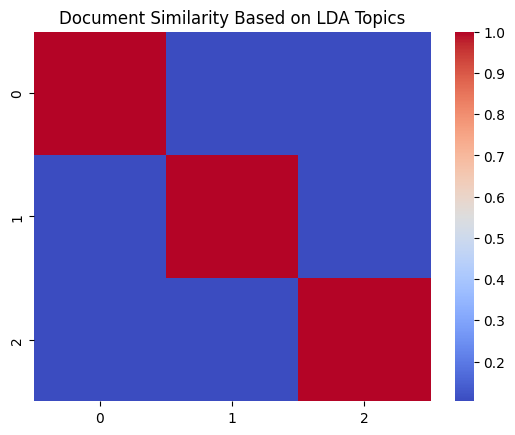

In [2]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sample text data
texts = [['text', 'of', 'document', 'one'],
         ['text', 'of', 'document', 'two'],
         ['text', 'of', 'document', 'three']]

# Create a dictionary and corpus
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Train LDA model
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Get topic distributions for each document
topic_distributions = [lda_model.get_document_topics(bow, minimum_probability=0) for bow in corpus]

# Convert the topic distributions into vectors
def vectorize_topics(distribution, num_topics=5):
    vec = [0] * num_topics
    for topic, weight in distribution:
        vec[topic] = weight
    return vec

topic_vectors = np.array([vectorize_topics(dist) for dist in topic_distributions])

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(topic_vectors)

# Plot heatmap
sns.heatmap(similarity_matrix, cmap='coolwarm')
plt.title('Document Similarity Based on LDA Topics')
plt.show()
